# Clustering Analysis

The clustering approach was to first determine clusters using Kmeans and DBSCAN to identify the most similar groups. A medium/high dimensional dataset was used for Kmeans, while a low dimentional dataset of only rodent sightings was used for DBSCAN. The second step was to identify and adjust the hyperparameters to identify anomalies in the dataset. Finally, the results of both approaches are compared. 


In [ ]:
from datetime import datetime, timedelta
import geopandas as gpd
import json
import pandas as pd
import mapclassify
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from io import StringIO
import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", None)
np.set_printoptions(threshold=np.inf)

In [2]:
# Parameters
parent_dir = os.path.abspath('..')  # get the absolute path of the parent directory
file_path = os.path.join(parent_dir, 'Data', 'rodents_per_year_merged.csv')  # construct the file path
rodents_df = pd.read_csv(file_path)
print(len(rodents_df))
rodents_df.head()

38958


,spatial_id,year,l_Commercial_sum,l_Other_sum,l_Outdoor_sum,l_Residential_sum,l_Residential-Mixed_sum,l_Vacant_Space_sum,d_Friday_sum,d_Monday_sum,d_Saturday_sum,d_Sunday_sum,d_Thursday_sum,d_Tuesday_sum,d_Wednesday_sum,t_Evening_sum,t_Midday_sum,t_Morning_sum,num_sightings,s_Dead_Animal:Residential_sum,s_Dead_Animal:Street_sum,s_Dog_waste:Street_sum,s_Illegal_Dumping:Street_sum,s_Trash:Residential_sum,s_Trash:Street_sum,s_Trash_MissedService:Street_sum,s_Trash_Overflowing:Street_sum,s_Trash_Time:Street_sum,s_Trash_Unsecure:Residential_sum,s_Trash_Unsecure:Street_sum,num_dsny_complaints,subway_count,v_flies_sum,v_rats/mice_sum,v_roaches_sum,c_American_sum,c_Bakery Products/Desserts_sum,c_Caribbean_sum,c_Chinese_sum,c_Coffee/Tea_sum,c_Italian_sum,c_Japanese_sum,c_Latin American_sum,c_Mexican_sum,c_Pizza_sum,c_other_sum,num_violations
0,360050001000,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,360050001000,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,360050001000,2022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,360050001000,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,360050001000,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Feature Selection

In [3]:
df = rodents_df.filter(regex='^(?!t_|d_|l_).*')
#df = df[df['year']==2019]
df = df.drop(['year','spatial_id','num_dsny_complaints','num_violations'], axis=1)

In [4]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [5]:
# calculate the correlation matrix
corr_matrix = df_scaled.corr()

# find the fields with the highest correlation to the target variable
target_var = 'num_sightings'
corr_values = corr_matrix[target_var]
highest_corr_fields = list(corr_values[corr_values.abs() > 0.05].index)

# create a new dataframe with only the selected fields
df_new = df_scaled[highest_corr_fields]
df_new.head()

,num_sightings,s_Illegal_Dumping:Street_sum,s_Trash:Residential_sum,s_Trash:Street_sum,s_Trash_Overflowing:Street_sum,s_Trash_Time:Street_sum,s_Trash_Unsecure:Residential_sum,s_Trash_Unsecure:Street_sum,subway_count,v_flies_sum,v_rats/mice_sum,v_roaches_sum,c_American_sum,c_Coffee/Tea_sum,c_Mexican_sum,c_Pizza_sum,c_other_sum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
highest_corr_fields

['num_sightings',
 's_Illegal_Dumping:Street_sum',
 's_Trash:Residential_sum',
 's_Trash:Street_sum',
 's_Trash_Overflowing:Street_sum',
 's_Trash_Time:Street_sum',
 's_Trash_Unsecure:Residential_sum',
 's_Trash_Unsecure:Street_sum',
 'subway_count',
 'v_flies_sum',
 'v_rats/mice_sum',
 'v_roaches_sum',
 'c_American_sum',
 'c_Coffee/Tea_sum',
 'c_Mexican_sum',
 'c_Pizza_sum',
 'c_other_sum']

In [19]:
# Choose all columns
cols_all = rodents_gdf.columns[3:-1] # (ALL COLUMNS)

# Cols gathered from pca notebook (ALL IMPORTANT COLUMNS ACROSS FIRST 5 PCAs)
cols_top_5_pca = ['l_Outdoor_sum', 'c_Italian_sum', 'l_Other_sum', 'c_Coffee/Tea_sum', 'subway_count', 'c_American_sum', 'l_Vacant_Space_sum', 'c_Caribbean_sum', 'l_Residential-Mixed_sum', 's_Trash_Unsecure:Street_sum', 'num_violations', 'v_flies_sum', 's_Dog_waste:Street_sum', 's_Trash_Unsecure:Residential_sum', 'v_rats/mice_sum', 's_Dead_Animal:Street_sum', 'c_Bakery Products/Desserts_sum', 's_Trash:Street_sum', 'c_Latin American_sum', 'v_roaches_sum', 's_Trash:Residential_sum', 's_Trash_Time:Street_sum', 'c_Chinese_sum', 's_Trash_Overflowing:Street_sum', 'c_other_sum', 'l_Residential_sum', 'c_Pizza_sum', 's_Illegal_Dumping:Street_sum', 's_Dead_Animal:Residential_sum', 's_Trash_MissedService:Street_sum']

# Cols gathered from pca notebook (ALL IMPORTANT COLUMNS FROM PCA 1)
cols_top_pca = ['num_violations', 'v_rats/mice_sum', 'v_flies_sum', 'c_other_sum', 'v_roaches_sum', 'c_American_sum', 'c_Coffee/Tea_sum', 'c_Chinese_sum', 'c_Italian_sum', 'c_Pizza_sum']


# K Means

In [7]:
# Range of k values to try
k_values = range(2, 11)

# Loop over k values and compute silhouette score for each, and inertia
for k in k_values:
    # Fit KMeans model
    kmeans = KMeans(n_clusters=k, random_state=42).fit(df_new)
    # Compute silhouette score
    score = silhouette_score(df_new, kmeans.labels_)
    # Compute Inertia 
    inertia = kmeans.inertia_
    print(f"For k={k}, silhouette score={score:.3f}, inertia:{inertia:.3f}")

For k=2, silhouette score=0.700, inertia:537.080
For k=3, silhouette score=0.476, inertia:486.568
For k=4, silhouette score=0.484, inertia:447.320
For k=5, silhouette score=0.491, inertia:412.757
For k=6, silhouette score=0.496, inertia:386.122
For k=7, silhouette score=0.500, inertia:357.351
For k=8, silhouette score=0.468, inertia:335.098
For k=9, silhouette score=0.474, inertia:317.963
For k=10, silhouette score=0.356, inertia:303.519


In [8]:
# Choosing k=7 for the number of clusters
clusters = 7

In [9]:
# Fit KMeans model
kmeans = KMeans(n_clusters=clusters, random_state=42).fit(df_new)

# Add cluster labels to original dataframe
rodents_df['cluster'] = kmeans.labels_

In [10]:
rodents_df.head()

,spatial_id,year,l_Commercial_sum,l_Other_sum,l_Outdoor_sum,l_Residential_sum,l_Residential-Mixed_sum,l_Vacant_Space_sum,d_Friday_sum,d_Monday_sum,d_Saturday_sum,d_Sunday_sum,d_Thursday_sum,d_Tuesday_sum,d_Wednesday_sum,t_Evening_sum,t_Midday_sum,t_Morning_sum,num_sightings,s_Dead_Animal:Residential_sum,s_Dead_Animal:Street_sum,s_Dog_waste:Street_sum,s_Illegal_Dumping:Street_sum,s_Trash:Residential_sum,s_Trash:Street_sum,s_Trash_MissedService:Street_sum,s_Trash_Overflowing:Street_sum,s_Trash_Time:Street_sum,s_Trash_Unsecure:Residential_sum,s_Trash_Unsecure:Street_sum,num_dsny_complaints,subway_count,v_flies_sum,v_rats/mice_sum,v_roaches_sum,c_American_sum,c_Bakery Products/Desserts_sum,c_Caribbean_sum,c_Chinese_sum,c_Coffee/Tea_sum,c_Italian_sum,c_Japanese_sum,c_Latin American_sum,c_Mexican_sum,c_Pizza_sum,c_other_sum,num_violations,cluster
0,360050001000,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,360050001000,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,360050001000,2022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,360050001000,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,360050001000,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [11]:
parent_dir = os.path.abspath('..')  # get the absolute path of the parent directory
file_path = os.path.join(parent_dir, 'Data', 'nyc_bgrp.geojson')  # construct the file path
cb_gdf = gpd.read_file(file_path)  # load the GeoJSON file into a GeoDataFrame
rodents_df['spatial_id'] = rodents_df['spatial_id'].astype(str)
rodents_joined_tracts_gdf = pd.merge(cb_gdf[['geometry','spatial_id']], rodents_df, how='left')


<AxesSubplot:>

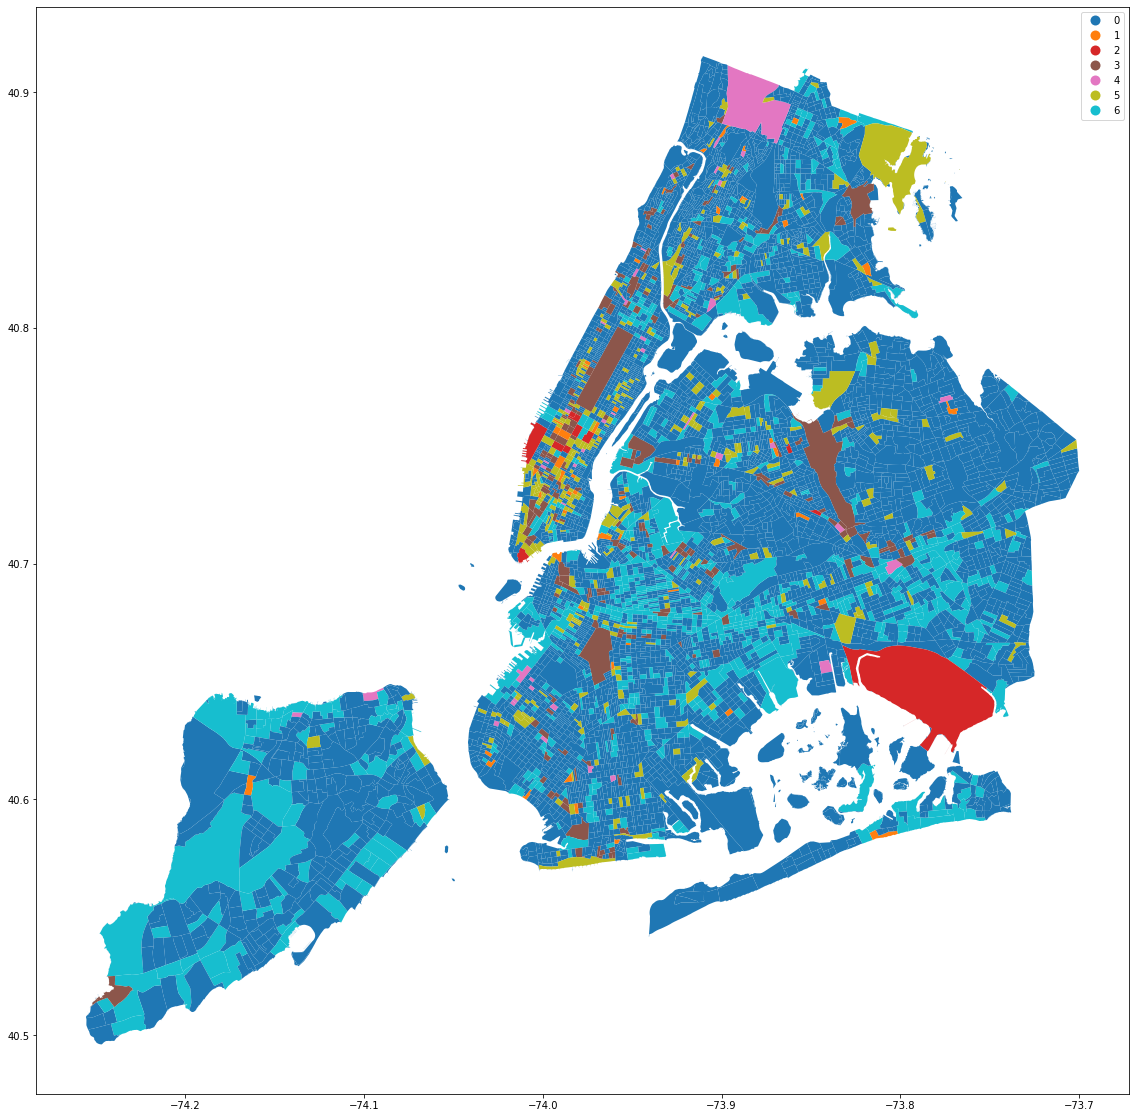

In [12]:
rodents_2019_df = rodents_joined_tracts_gdf[rodents_joined_tracts_gdf['year']==2019]
rodents_2019_df.plot(column='cluster', cmap='tab10', categorical=True, figsize=(20, 20), legend=True)

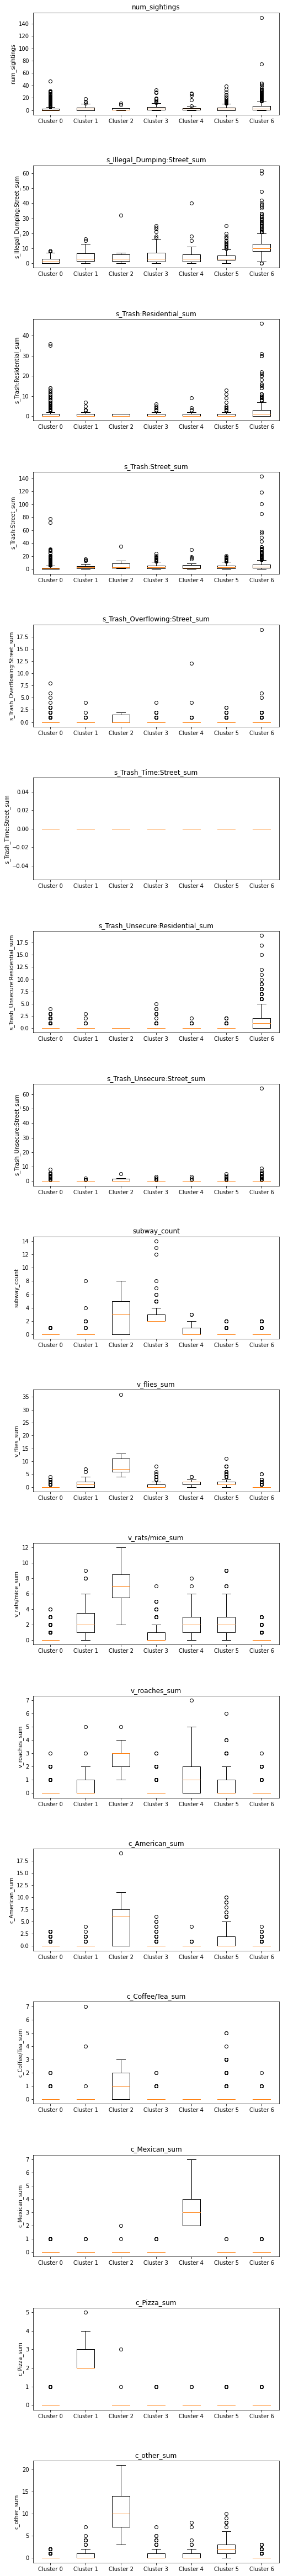

In [13]:
# Set up subplots for each variable
fig, axs = plt.subplots(nrows=len(highest_corr_fields), figsize=(8, 5*len(highest_corr_fields)))
plt.subplots_adjust(hspace=0.5)

# Loop over variables and create box and whisker plot for each
for i, col in enumerate(highest_corr_fields):
    # Create a list of dataframes for each cluster
    cluster_dfs = []
    for cluster_num in range(0, clusters):
        cluster_df = rodents_2019_df[rodents_2019_df['cluster'] == cluster_num]
        cluster_dfs.append(cluster_df)
        
    # Plot box and whisker for each cluster
    axs[i].boxplot([df[col] for df in cluster_dfs])
    cluster_labels = ['Cluster {}'.format(i) for i in range(clusters)]
    axs[i].set_xticklabels(cluster_labels)
    axs[i].set_title(col)
    axs[i].set_ylabel(col)
    
plt.show()

# KMeans Anomalies

In [18]:
# TODO Kmeans Anomaly detection

# DBSCAN 

DBScan is useful for finding clusters based on geographic location. Typically this is done with a low dimentional dataset, typically just latitude and longitude plus perhaps one variable. We attempted to use many more columns, but the result had low [insert cluster eval type and results]. One caveat for our analysis is that we are using an aggrgate count of rodent sightings per census block for which the centroid latitude and longitude was derived. 

The first step was to transform the geographic units to an equal distance projection so that distances between the latitudes and longitudes are equivalent, without any distortion from projections. 

To determine the appropriate vlaus for espeilon and the number of minimum samples, an iterative approach was used.

The silhouette score measures how well each data point fits into its assigned cluster compared to other clusters. 
A score close to 1 indicates that the data point is assigned to the correct cluster, 
while a score close to -1 indicates that the data point is assigned to the wrong cluster.

The Calinski-Harabasz index measures the ratio of between-cluster variance to within-cluster variance. 
A higher score indicates that the clusters are well-separated.

The Davies-Bouldin index measures the average similarity between each cluster and its most similar cluster. 
A lower score indicates that the clusters are well-separated.

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a popular clustering algorithm that groups together data points based on their density in a given feature space. The algorithm works by identifying clusters of points that are closely packed together, separated by areas of lower point density. Unlike other clustering algorithms like K-means, DBSCAN can identify clusters of arbitrary shapes and is robust to noise.

Clusters with -1 are 'noise'

In [148]:
# Choose columns 

rodents_gdf = rodents_2019_df[rodents_2019_df.geometry.notnull()]

# An attempt to summarize over all 5 years
# cols = rodents_gdf.columns[3:]
# print(cols)
# rodents_gdf = rodents_gdf.groupby(['spatial_id'])[cols].sum().reset_index()

rodents_gdf.head()

original_crs = rodents_gdf.crs
equal_area_crs = {'proj': 'aea', 'lat_1': 29.5, 'lat_2': 45.5, 'lat_0': 23, 'lon_0': -96, 'x_0': 0, 'y_0': 0, 'datum': 'WGS84', 'units': 'm', 'no_defs': True}

# Make a copy of your original GeoDataFrame and reproject it
rodents_gdf_equal_area = rodents_gdf.to_crs(equal_area_crs)

# Check the new CRS
print(rodents_gdf_equal_area.crs)

# Only num rodent violations as a weight
cols = ['num_violations'] + cols_top_pca

# Extract the coordinates of the points
rodents_gdf['x'] = rodents_gdf.apply(lambda x: (x['geometry'].centroid.x), axis=1)
rodents_gdf['y'] = rodents_gdf.apply(lambda x: (x['geometry'].centroid.y), axis=1)

# Extract xy coordinates as features
X = rodents_gdf[['x', 'y']]

# Add additional variables to feature matrix
X = np.hstack((X, rodents_gdf[cols].values))

+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=23 +lon_0=-96 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs


In [149]:
# Scale xy coordinates
scaler = StandardScaler()
X = scaler.fit_transform(X)
# Scale features so that distances are not overfitting larger values


In [ ]:
# # Run DBSCAN (Manual Tests)
# dbscan = DBSCAN(eps=0.08, min_samples=7) 
# labels = dbscan.fit_predict(X)
# rodents_gdf['dbscan_clusters'] = labels
# rodents_gdf.plot(column='dbscan_clusters', cmap='rainbow', categorical=True, figsize=(20, 20), legend=True)

eps_values = np.arange(0.01, 0.1, 0.005)
min_samples_values = np.arange(5, 20, 1)

    silhouette -0.5648271991664244 0.019999999999999997 5
    calinski_harabasz 1.9951500111967087 0.019999999999999997 5
    davies_bouldin 1.7646830249171226 0.019999999999999997 5
    calinski_harabasz 3.954811619894201 0.024999999999999998 5
    davies_bouldin 1.5733511092022834 0.024999999999999998 5
    silhouette -0.5500611718706402 0.024999999999999998 6
    calinski_harabasz 4.7096839632124885 0.024999999999999998 6
    davies_bouldin 1.3183285478018314 0.024999999999999998 6
    silhouette -0.34554094414701886 0.024999999999999998 7
    calinski_harabasz 5.8036861813029965 0.024999999999999998 7
    davies_bouldin 1.1783684945034827 0.024999999999999998 7
    calinski_harabasz 6.051220003970459 0.03 6
    calinski_harabasz 6.994029650597017 0.03 8
    silhouette -0.34492380682671253 0.03 9
    silhouette -0.3110476477363486 0.03 10
    calinski_harabasz 7.6567697001691375 0.03 10
    silhouette -0.25296770582939276 0.03 11
    calinski_harabasz 8.772850439230023 0.034999999999999996 5
    calinski_harabasz 9.205611609468653 0.034999999999999996 9
    silhouette -0.25122642830825337 0.034999999999999996 13
    calinski_harabasz 18.48732369493235 0.039999999999999994 5
    calinski_harabasz 33.663670240877366 0.045 5
    calinski_harabasz 39.051711606207846 0.049999999999999996 6
    calinski_harabasz 51.79273616724257 0.05499999999999999 7
    calinski_harabasz 74.7133191707384 0.05999999999999999 7
    calinski_harabasz 95.6703114833628 0.06499999999999999 9
    calinski_harabasz 103.19068177231935 0.06999999999999999 13
    calinski_harabasz 112.53157134562925 0.07499999999999998 13
    calinski_harabasz 140.82710643096837 0.07499999999999998 14
    calinski_harabasz 141.34431844271342 0.07999999999999999 15
    calinski_harabasz 175.67464015650017 0.08499999999999998 17
    davies_bouldin 1.1749826221511426 0.08999999999999998 11
    silhouette -0.17887332166391784 0.08999999999999998 19
    calinski_harabasz 219.09515777909618 0.08999999999999998 19
    davies_bouldin 1.1662175893245696 0.09499999999999999 12
    Best eps: 0.09499999999999999
    Best min_samples: 12
    Best Silhouette Score: -0.17887332166391784
    Best Calinski-Harabasz Index: 219.09515777909618
    Best Davies-Bouldin Index: 1.1662175893245696

In [151]:
# Define the hyperparameter search space
eps_values = np.arange(0.001, 0.1, 0.005)
min_samples_values = np.arange(5, 20, 1)

# Initialize variables to store the best hyperparameters and their corresponding scores
best_eps = None
best_min_samples = None
best_silhouette = -1
best_calinski_harabasz = -1
best_davies_bouldin = float('inf')

# Perform a grid search
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)
        
        # Ignore cases where all data points are assigned to the same cluster (noise)
        if len(set(labels)) > 1:
            silhouette = silhouette_score(X, labels)
            calinski_harabasz = calinski_harabasz_score(X, labels)
            davies_bouldin = davies_bouldin_score(X, labels)

            # Update the best hyperparameters if the current combination yields better scores
            if silhouette > best_silhouette:
                print('silhouette {0} {1} {2}'.format(silhouette, eps, min_samples))
                best_silhouette = silhouette
                best_eps = eps
                best_min_samples = min_samples

            if calinski_harabasz > best_calinski_harabasz:
                print('calinski_harabasz {0} {1} {2}'.format(calinski_harabasz, eps, min_samples))
                best_calinski_harabasz = calinski_harabasz
                best_eps = eps
                best_min_samples = min_samples

            if davies_bouldin < best_davies_bouldin:
                print('davies_bouldin {0} {1} {2}'.format(davies_bouldin, eps, min_samples))
                best_davies_bouldin = davies_bouldin
                best_eps = eps
                best_min_samples = min_samples

# Print the best hyperparameters and their corresponding scores
print("Best eps:", best_eps)
print("Best min_samples:", best_min_samples)
print("Best Silhouette Score:", best_silhouette)
print("Best Calinski-Harabasz Index:", best_calinski_harabasz)
print("Best Davies-Bouldin Index:", best_davies_bouldin)


silhouette -0.6372196870974385 0.021 5
calinski_harabasz 0.8662321665970435 0.021 5
davies_bouldin 1.934692665194165 0.021 5
silhouette -0.4605280348860716 0.021 6
calinski_harabasz 1.1449725762695886 0.021 6
davies_bouldin 1.7773725979928483 0.021 6
silhouette -0.39819391274189225 0.021 7
calinski_harabasz 1.3443133700262988 0.026000000000000002 5
calinski_harabasz 1.7506559954817997 0.026000000000000002 6
davies_bouldin 1.6803310441764516 0.026000000000000002 6
davies_bouldin 1.497300291190323 0.026000000000000002 7
silhouette -0.39803788360330716 0.026000000000000002 8
calinski_harabasz 1.887737825328271 0.031 5
calinski_harabasz 2.07555583236357 0.031 6
calinski_harabasz 2.1534099536861695 0.031 8
calinski_harabasz 2.2562415432257144 0.031 9
silhouette -0.3967595793039364 0.031 11
silhouette -0.3266534377630343 0.036000000000000004 5
calinski_harabasz 3.151595858571682 0.036000000000000004 5
calinski_harabasz 3.197706206676542 0.036000000000000004 10
calinski_harabasz 3.22990780947

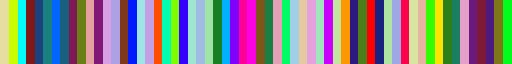

In [125]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, hsv_to_rgb

# Number of distinct colors you need
n_colors = 20
hues = np.linspace(0, 1, n_colors + 1)[:-1]
hsv_colors = np.zeros((n_colors, 3))
hsv_colors[:, 0] = hues
hsv_colors[:, 1] = 0.99
hsv_colors[:, 2] = 0.99 
rgb_colors1 = hsv_to_rgb(hsv_colors)

hsv_colors2 = np.zeros((n_colors, 3))
hsv_colors2[:, 0] = hues
hsv_colors2[:, 1] = 0.3
hsv_colors2[:, 2] = 0.9 
rgb_colors2 = hsv_to_rgb(hsv_colors2)

hsv_colors3 = np.zeros((n_colors, 3))
hsv_colors3[:, 0] = hues
hsv_colors3[:, 1] = 0.8
hsv_colors3[:, 2] = 0.5
rgb_colors3 = hsv_to_rgb(hsv_colors3)

colors = np.vstack([rgb_colors1,rgb_colors2,rgb_colors3])
np.random.shuffle(colors)

# Create a custom colormap using the generated colors
custom_cmap = ListedColormap(colors)
custom_cmap

<AxesSubplot:>

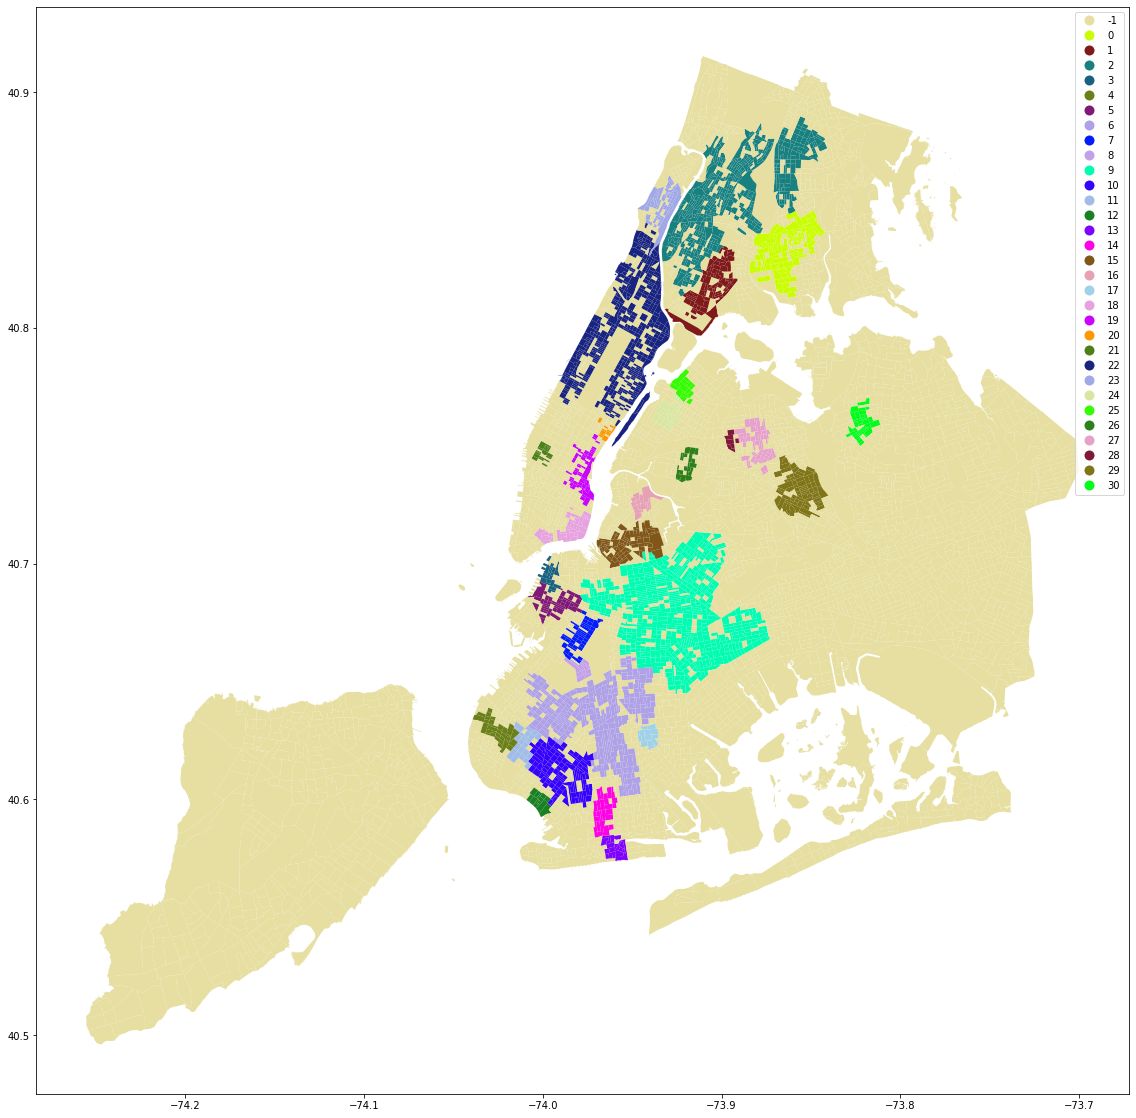

In [160]:
# Apply the hyperparameters 

# Run DBSCAN
dbscan = DBSCAN(eps=0.061, min_samples=12) # 31 clusters 

labels = dbscan.fit_predict(X)

rodents_gdf['dbscan_clusters'] = labels

rodents_gdf.plot(column='dbscan_clusters', cmap=custom_cmap, categorical=True, figsize=(20, 20), legend=True)

In [161]:
rodents_gdf['is_dbscan_noise'] = rodents_gdf.apply(lambda x: True if x['dbscan_clusters']<0 else False, axis=1)
dbscan_noise_df = rodents_gdf.groupby(['is_dbscan_noise'])['num_sightings'].count().reset_index()
total_sightings = dbscan_noise_df.num_sightings.sum()
dbscan_noise_df['sightings_percent'] = dbscan_noise_df['num_sightings'] / total_sightings
dbscan_noise_df

,is_dbscan_noise,num_sightings,sightings_percent
0,False,2610,0.403837
1,True,3853,0.596163


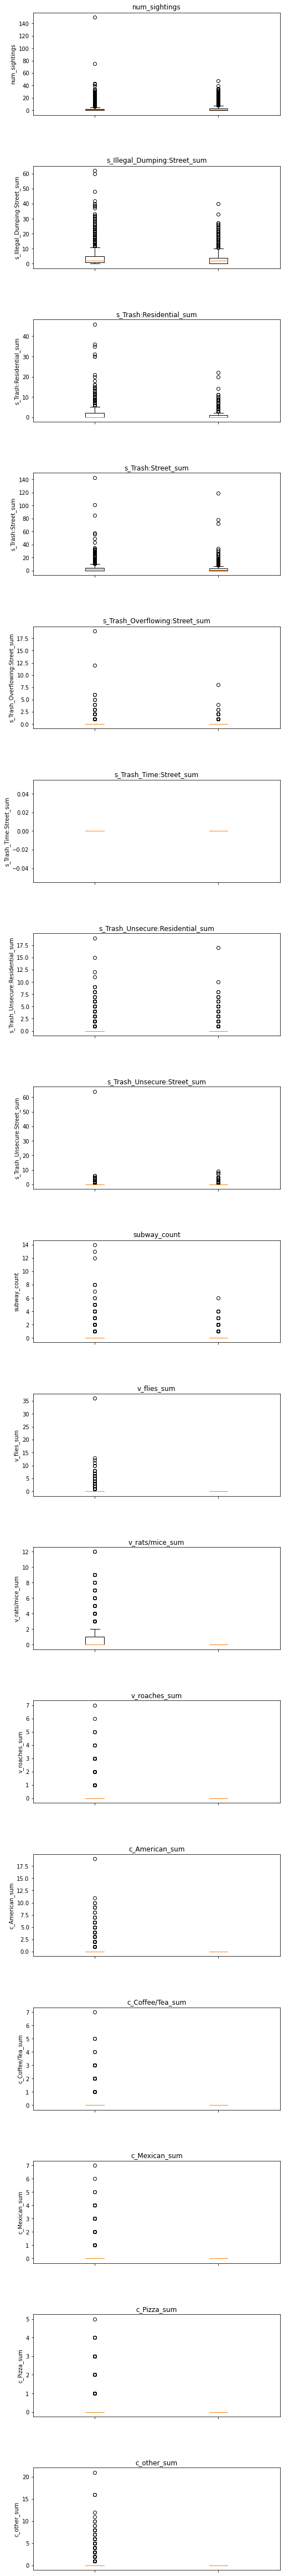

In [169]:
# Set up subplots for each variable
fig, axs = plt.subplots(nrows=len(highest_corr_fields), figsize=(8, 5*len(highest_corr_fields)))
plt.subplots_adjust(hspace=0.5)

# Loop over variables and create box and whisker plot for each
for i, col in enumerate(highest_corr_fields):
    # Create a list of dataframes for each cluster
    group_dfs = []
    group = [True, False]
    for group in group:
        group_df = rodents_gdf[rodents_gdf['is_dbscan_noise'] == group]
        group_dfs.append(group_df)
        
    # Plot box and whisker for each cluster
    axs[i].boxplot([df[col] for df in group_dfs])
    cluster_labels = ['Cluster {}'.format(str(i)) for i in range(group)]
    axs[i].set_xticklabels(cluster_labels)
    axs[i].set_title(col)
    axs[i].set_ylabel(col)
    
plt.show()

In [15]:
# TODO Describe these clusters

# What percent of rodent complaints happen in these xx percent of census tracts

# Can i find which eps and min samples gives the 80/20 rule. 
# 80% of the complaints happening in 20% of the census tracts? Does the pareto rule apply? Seems like no. 

# DBSCAN Anomalies

To determine which areas had the most anamoulous rodent sightings, 

Filter the clusters to only the ones where there are fewer than 5% of the census block groups as clusters(i.e. very few clusters). 

Iterate over all results of the anomalies to find all possible epsilon and min sample hyperparameters that result in anomalies. Then, summarize the number of times the census block group is identified as an anomaly. 

Take the results of the summarization and create a heat map (choropleth) to show where the anomalies occur. 

Run this over each year and compare the output maps.

This approach can help sanitation workers pinpoint intervention on hotspots and could be thought of as a form of ensemble anomaly detection, as it combines the results of multiple DBSCAN models with different hyperparameters to identify the most frequently occurring anomalies.

This method of analyzing rodent sightings could be considered as a form of ensemble anomaly detection since it iterates over multiple combinations of hyperparameters (epsilon and min_samples) to identify anomalies. The summarized results then indicate the consensus of these different models regarding the anomalous regions.

In [184]:
rodents_gdf['time_anomalous'] = 0

total_num_samples = len(X[:,0])
max_eps = 0.3 # Tight clusters 

for eps in np.logspace(np.log10(max_eps) - 3, np.log10(max_eps), 20):
    for min_samples in range(5, 200, 2):
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
        num_clustered = len(db.labels_[db.labels_ >= 0])
        if (num_clustered > 0) & (num_clustered < 0.05 * total_num_samples):
            print("eps =", eps, ", min_samples =", min_samples, ", num_detected_points =", len(db.labels_[db.labels_ >= 0]))
            rodents_gdf['dbscan_clusters'] = db.labels_
            
            # Update the time_anomalous column to count the number of times each row is flagged as an anomaly
            rodents_gdf['time_anomalous'] += np.where(rodents_gdf['dbscan_clusters'] > 0, 1, 0)



eps = 0.02354279911054384 , min_samples = 7 , num_detected_points = 24
eps = 0.03386513675054066 , min_samples = 9 , num_detected_points = 238
eps = 0.03386513675054066 , min_samples = 11 , num_detected_points = 44
eps = 0.03386513675054066 , min_samples = 13 , num_detected_points = 19
eps = 0.048713302175661645 , min_samples = 17 , num_detected_points = 210
eps = 0.048713302175661645 , min_samples = 19 , num_detected_points = 91
eps = 0.048713302175661645 , min_samples = 21 , num_detected_points = 45
eps = 0.07007164407270366 , min_samples = 29 , num_detected_points = 311
eps = 0.07007164407270366 , min_samples = 31 , num_detected_points = 241
eps = 0.07007164407270366 , min_samples = 33 , num_detected_points = 142
eps = 0.07007164407270366 , min_samples = 35 , num_detected_points = 37
eps = 0.07007164407270366 , min_samples = 37 , num_detected_points = 37
eps = 0.10079454858851347 , min_samples = 53 , num_detected_points = 318
eps = 0.10079454858851347 , min_samples = 55 , num_detect

In [185]:
rodents_gdf.time_anomalous.value_counts()

0     6070
1      117
4       70
2       53
5       45
3       32
6       19
13      14
10      11
8        9
14       7
9        6
7        4
12       4
11       2
Name: time_anomalous, dtype: int64

In [192]:
fig, ax = plt.subplots(figsize=(15, 15))
rodents_gdf.plot(column='time_anomalous', 
                 scheme='natural_breaks', 
                 k=5, 
                 cmap='OrRd', 
                 edgecolor='k', 
                 ax=ax,
                 linewidth=0.01,
                 legend=True)

# Save the figure as a PNG file
plt.savefig('rodent_anomalies.png', dpi=300, bbox_inches='tight')
plt.close()